In [3]:
# %load import.py
import ILPmodel as ILP
import ILPtry as ILPtry
from skimage.filters import gaussian

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
%reload_ext autoreload
%autoreload 2
from tifffile import imread, imsave
import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


Stack shape: (75, 2, 356, 610)
Segchannel shape: (75, 356, 610)
Single image: (356, 610)


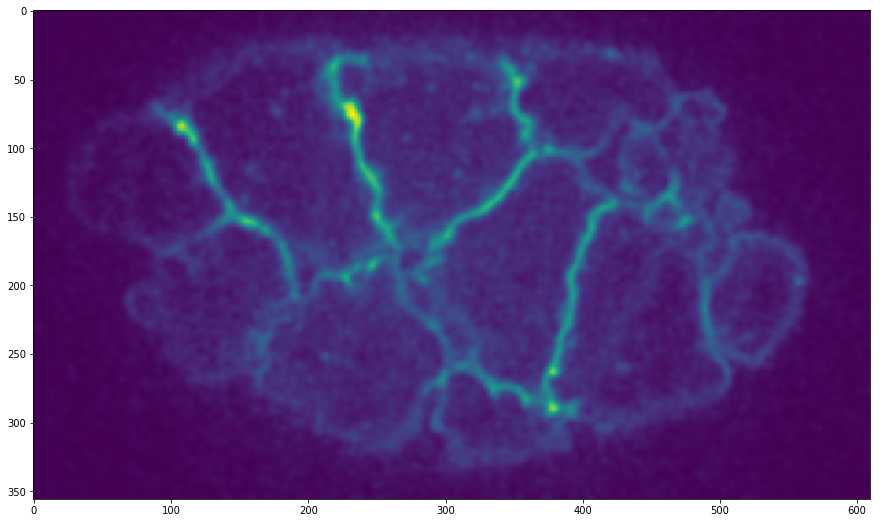

In [3]:
name = '4MyosinMembraneWholeEmbryo'
filename = '/home/agupta/BobSeg/data/' +name + '.tif'
stack = imread(filename)
print 'Stack shape:',stack.shape
segchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)
print 'Segchannel shape:',segchannel.shape
print 'Single image:',segchannel[0].shape

#center = (170, 250)
center = (350,180)
max_radius = (segchannel[0].shape[1] / 5,
          segchannel[0].shape[1] / 5)
min_radius = (10,10)
segimages = segchannel_smooth
images = [None] * segimages.shape[0]
for i in range (segimages.shape[0]):
    images[i] = segimages[i]     
    
imshow(images[1])

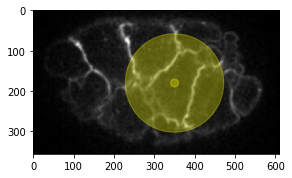

In [4]:
frame = 0
fig = plt.figure()
ax = plt.subplot(131)
ax.imshow(images[frame], plt.get_cmap('gray'))


patches = [] # collects patches to be plotted
patches.append( ILP.Ellipse((center[0],center[1]),
                        width=(min_radius[0]*2),
                        height=(min_radius[1])*2) )
patches.append( ILP.Ellipse((center[0],center[1]),
                        width=(max_radius[0]*2),
                        height=(max_radius[1]*2)) )
p = ILP.PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.3, color='yellow')
ax.add_collection(p)

## Setting up parameters
N = number of columns  <br />
K = number of nodes on each column  <br />
max_delta_k = adjacent nodes  <br />
T = number of time frames  <br />
max_delta_time = parameter to intrcorporate temporal smoothness  <br />

In [5]:
N = 60
K = 30
max_delta_k = 4
max_delta_time = 2
T = segimages.shape[0]
#T = 1
alpha = 1
alpha_t =0
beta= 0.005
beta_t=0.001
nodes = N * K

w = ILP.compute_vertex_cost(T, N, K, images, center, min_radius, max_radius)
w_edge = ILP.compute_edge_cost(T, N, K, max_delta_k, alpha, beta, w)
w_e = ILP.compute_temporal_edge_cost(T, N, K, max_delta_time, alpha_t, beta_t, w)

In [ ]:
w

array([[[-0.09850833, -0.08404882, -0.10381239, ..., -0.09788926,
         -0.0943683 , -0.11174206],
        [-0.096997  , -0.08052631, -0.09421846, ..., -0.07331757,
         -0.07266212, -0.09013424],
        [-0.0981006 , -0.08095261, -0.08151884, ..., -0.08173963,
         -0.08327584, -0.07694832],
        ..., 
        [-0.10907548, -0.10164151, -0.0970267 , ..., -0.20013253,
         -0.19402855, -0.24307475],
        [-0.10907548, -0.10497808, -0.09276922, ..., -0.15773095,
         -0.17525898, -0.23796417],
        [-0.10907548, -0.10022807, -0.08860039, ..., -0.13642268,
         -0.11877124, -0.11255249]],

       [[-0.11327832, -0.09576608, -0.10645466, ..., -0.09365749,
         -0.08798607, -0.09549658],
        [-0.11777888, -0.10334272, -0.1049841 , ..., -0.06679099,
         -0.06294347, -0.05819542],
        [-0.11903968, -0.1014137 , -0.1003823 , ..., -0.07391544,
         -0.04765692, -0.04691694],
        ..., 
        [-0.11273476, -0.10117659, -0.1014768 , ...,

In [6]:
#m, vv = ILP.test_model_without_edge(T, N, K, w)
#m, vv, ve = ILP.test_model_without_temporal(T, N, K, w, w_edge)
m, vv, ve = ILP.build_model(T, N, K, w, w_edge, w_e)
print '\n'
m.optimize()


DEFINING VARIABLES AND COSTS . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
SETTING OBJECTIVE FUNCTION . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
SETTING CONSTRAINTS . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

|Vv| =  135000
|Ve| =  2403720
|CONSTRAINTS| =  549840


Optimize a model with 549840 rows, 1899360 columns and 5964480 nonzeros
Variable types: 0 continuous, 1899360 integer (1899360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-15, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time =

In [7]:
def plot_surfaces(T, images, surfaces, folder):
    for t in range(T):
        fig = plt.figure()
        ax = plt.subplot()
        ax.imshow(images[t], plt.get_cmap('gray'))
        patches = [] 
        polygon = Polygon(surfaces[t], True)
        patches.append(polygon)
        p = ILP.PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4, color='blue')
        ax.add_collection(p)
        savefig(folder + 'frame' + str(t) + '.png')

In [8]:
%%capture

surfaces = ILP.get_surfaces(T, N, K, min_radius, max_radius, center, m, vv )
#folder = '/home/agupta/BobSeg/ILP_TEST_OUTPUTS/' + name
folder = '/home/agupta/BobSeg/ILP_TEST_OUTPUTS/' + name+ '_alpha1beta01_beta_t_001_'

plot_surfaces(T, images, surfaces, folder)

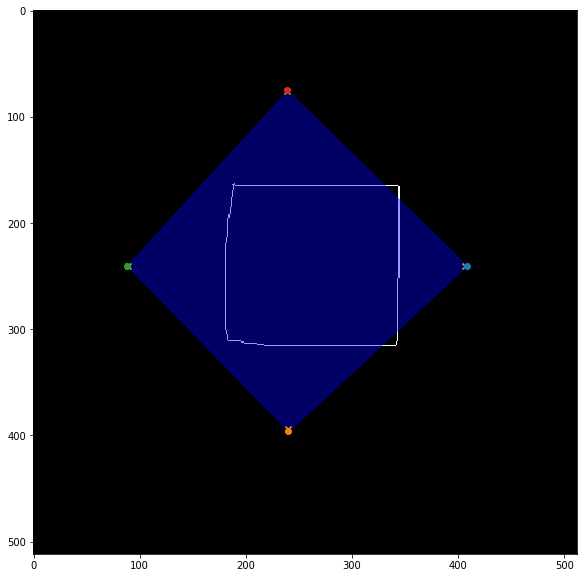

In [47]:
surfaces = []
temp_vv = m.getAttr("X", vv)
col_vectors = ILP.sample_circle(N)

for t in range(T):
    surface = []
    for i in range(N):
        from_x = int(center[0] + col_vectors[i,0]*min_radius[0])
        from_y = int(center[1] + col_vectors[i,1]*min_radius[1])
        to_x = int(center[0] + col_vectors[i,0]*max_radius[0])
        to_y = int(center[1] + col_vectors[i,1]*max_radius[1])
        coords = ILP.bham.bresenhamline(np.array([[from_x, from_y]]), np.array([[to_x, to_y]]))
        num_pixels = len(coords)
        for k in range(K):
            if(temp_vv[(i*K+k)*T+t] == 1 and k !=0):
                #print k
                #k +=1
                start = int(k * float(num_pixels)/K)
                end = max( start+1, start + num_pixels/K )
                x = int(center[0] + col_vectors[i,0] * 
                    min_radius[0] + col_vectors[i,0] * 
                    (k-1)/float(K) * (max_radius[0]-min_radius[0]) )
                y = int(center[1] + col_vectors[i,1] * 
                    min_radius[1] + col_vectors[i,1] * 
                    (k-1)/float(K) * (max_radius[1]-min_radius[1]) )
                surface.append((coords[(start+end)/2][0],coords[(start+end)/2][1]))
                #surface.append((x,y))
    surface.append(surface[0])
    surfaces.append(surface)
    
for t in range(T):
    fig = plt.figure()
    ax = plt.subplot()
    ax.imshow(images[t], plt.get_cmap('gray'))
    patches = [] 
    polygon = Polygon(surfaces[t], True)
    patches.append(polygon)
    p = ILP.PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4, color='blue')
    ax.add_collection(p)
    for i in range(N):
        
        #print coords.shape[0]
        #for temp in range(coords.shape[0]):
           # ax.scatter(coords[temp][0],coords[temp][1], c='y', marker='.')
        from_x = int(center[0] + col_vectors[i,0]*min_radius[0])
        from_y = int(center[1] + col_vectors[i,1]*min_radius[1])
        to_x = int(center[0] + col_vectors[i,0]*max_radius[0])
        to_y = int(center[1] + col_vectors[i,1]*max_radius[1])
        coords = ILP.bham.bresenhamline(np.array([[from_x, from_y]]), np.array([[to_x, to_y]]))
        
        #ax.scatter(from_x,from_y, c='r', marker='x')
        #ax.scatter(to_x,to_y, c='r', marker='x')
        num_pixels = len(coords)
        for k in range(K):
            if(temp_vv[(i*K+k)*T+t] == 1 and k!=0):
                
                start = int(k * float(num_pixels)/K)
                end = max( start+1, start + num_pixels/K )
                #print i,k
                k += 1
                x = int(center[0] + col_vectors[i,0] * 
                    min_radius[0] + col_vectors[i,0] * 
                    (k-1)/float(K) * (max_radius[0]-min_radius[0]) )
                y = int(center[1] + col_vectors[i,1] * 
                    min_radius[1] + col_vectors[i,1] * 
                    (k-1)/float(K) * (max_radius[1]-min_radius[1]) )
                ax.scatter(x,y, c='y', marker='x')
                ax.scatter(coords[(start+end)/2][0], coords[(start+end)/2][1], marker = 'o')
        ax.imshow(images[t], plt.get_cmap('gray'))
        #savefig(folder + 'frame_' + str(t) + '.png')

In [ ]:
print num_pixels
